### Import packages

In [1]:

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
from torch.optim import lr_scheduler
import cv2
import os
from os import path
import json
import time
import copy
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum

import pandas as pd
from PIL import Image
import random
import torchvision.transforms as T
from torch.utils.data import Dataset

#if gpu, use it
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


### Extract frames from videos and place them inside video name folder

In [ ]:
 def extract_frames(file_path, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    vidcap = cv2.VideoCapture(file_path)
    success, image = vidcap.read()
    count = 0
 
    while success:
        frame_path = os.path.join(target_dir, f'{count}.jpg')
        cv2.imwrite(frame_path, image)     # save frame as JPEG file
        count += 1
        success, image = vidcap.read()
        success, image = vidcap.read()
        success, image = vidcap.read()


root = 'D:/Documentos/INESC/teste/videos'
frame_root = 'D:/Documentos/INESC/teste/video_frames'
labels_path = 'D:/Documentos/INESC/teste/labels.csv'
class_name_to_label_path = 'D:/Documentos/INESC/teste/class_name_to_label.json'

#read files
files = []

for class_name in os.listdir(root):
    for video_name in os.listdir(os.path.join(root, class_name)):
         files.append([os.path.join(class_name, video_name), class_name])

#normalize labels
class_name_to_label = {}
current_label = -1

for vid in files:
    label = class_name_to_label.get(vid[1], -1)

    if label == -1:
        current_label += 1
        class_name_to_label[vid[1]] = current_label
        label = current_label

    vid[1] = label


# save file paths
if not os.path.exists(os.path.split(labels_path)[0]):
     os.makedirs(os.path.split(labels_path)[0])

f = open(labels_path, 'w')

f.write('path,label\n')

for vid in files:
    f.write(f'{vid[0]},{vid[1]}\n')

f.close()

 # save label normalization
if not os.path.exists(os.path.split(class_name_to_label_path)[0]):
    os.makedirs(os.path.split(class_name_to_label_path)[0])

with open(class_name_to_label_path, 'w') as json_file:
    json.dump(class_name_to_label, json_file, indent=4)

# extract frames
for i, vid in enumerate(files):
    file_path = os.path.join(root, vid[0])
    target_dir = os.path.join(frame_root, vid[0])

    extract_frames(file_path, target_dir)

    print(f'{i+1}/{len(files)}')

### Split labels csv file into train and validate - 80/20

In [ ]:
 import pandas as pd

def split(label, path):
    train = label.sample(frac=0.8, random_state=201)
    val = label.drop(train.index)
    train.to_csv(path + '/train.csv', mode='a', header=False)
    val.to_csv(path + '/val.csv', mode='a', header=False)


root = 'D:/Documentos/INESC/teste/'
frame_root = 'D:/Documentos/INESC/teste/video_frames'
labels_path = 'D:/Documentos/INESC/teste/labels.csv'
class_name_to_label_path = 'D:/Documentos/INESC/teste/class_name_to_label.json'

labels_data = pd.read_csv(labels_path)
last_label = labels_data.tail(1)['label']
last_label = last_label.iloc[0]
max_labels = labels_data.nunique()
max_labels = max_labels['label']
print(max_labels)
index = 0

for i in range(max_labels):
    label = labels_data[labels_data['label'] == index]
    split(label, root)
    index +=1

### custom dataset

In [2]:

train_csv_path = 'D:/Documentos/INESC/teste/train.csv'
validate_csv_path = 'D:/Documentos/INESC/teste/val.csv'
root_path = 'D:/Documentos/INESC/teste/video_frames'

class MyDataset(Dataset):
    def __init__(self, frames_csv_file, root_dir):
        self.frames_csv = pd.read_csv(frames_csv_file)
        self.root_dir = root_dir
        self.slice_size = 10

    def __len__(self):
        return len(self.frames_csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
      
      #need to take 10 frames and stack them on 1 tensor                                                    
      #()-> second index has to be 1 because id column (3 columns) 
      #()-> why have to be NOT??? is wrong!! but works..
        all_frames = [f for f in os.listdir(os.path.join(self.root_dir, str(self.frames_csv.iloc[idx, 1]))) if not os.path.isfile(f)]
      #random get 10 consecutive frames from all video frames in folder
        if len(all_frames) > (self.slice_size):
            start = random.randrange(len(all_frames) - self.slice_size)
            frames = all_frames[start: start + self.slice_size]
        else:
            frames = all_frames
      
        images = []
      #load the images
        for frame in frames:
            path = os.path.join(self.root_dir, str(self.frames_csv.iloc[idx, 1])) + '/' + frame
            images.append(Image.open(path).convert('RGB'))
        transform = transforms.Compose([
                    T.Resize((240, 320),),
                    T.ToTensor(),
                    T.Normalize(mean = [0.43216, 0.394666, 0.37645], std = [0.22803, 0.22145, 0.216989])])
        #apply tansforms and condense all the images in 1 tensor
        tensors = []
        for image in images:
            tensors.append(transform(image))            
        final_image = torch.stack(tensors, dim=1)
        tag = int(self.frames_csv.iloc[idx, 2])
        return final_image, tag

train_dataset = MyDataset(train_csv_path, root_path)
validate_dataset = MyDataset(validate_csv_path, root_path)


In [3]:
## dataloaders

In [4]:

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=5, shuffle=True)
validate_dataloader = DataLoader(validate_dataset, batch_size=5, shuffle=True)

In [5]:
## training loop

In [34]:
def train_model(model, criterion, optimizer, scheduler, stats, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            if phase == 'train':
                    data, tag = next(iter(train_dataloader))
                #for data, tag in train_dataloader:
                    data = data.to(device)
                    tag = tag.to(device)

              # zero the parameter gradients
                    optimizer.zero_grad()

              # forward
              # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(data)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, tag)
    # backward + optimize only if in training phase
                        loss.backward()
                        optimizer.step()
                  

              # statistics
                    running_loss += loss.item() * data.size(0)
                    running_corrects += torch.sum(preds == tag)
            
                    scheduler.step()
                    #unindent this!
                    epoch_loss = running_loss / len(train_dataset)
                    epoch_acc = running_corrects.double() / len(train_dataset)
                    stats[phase + '_loss'].append(float(epoch_loss))
                    stats[phase + '_acc'].append(float(epoch_acc))
            else:
                #for data, tag in validate_dataloader:
                    data, tag = next(iter(validate_dataloader))
                    data = data.to(device)
                    tag = tag.to(device)

                # zero the parameter gradients
                    optimizer.zero_grad()

                # forward
                # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(data)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, tag)

                # statistics
                    running_loss += loss.item() * data.size(0)
                    running_corrects += torch.sum(preds == tag)
                    #unindent this!
                    epoch_loss = running_loss / len(validate_dataset)
                    epoch_acc = running_corrects.double() / len(validate_dataset)
                    stats[phase + '_loss'].append(float(epoch_loss))
                    stats[phase + '_acc'].append(float(epoch_acc))

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
## prepare the model

In [8]:
class_name_to_label_path = 'D:/Documentos/INESC/teste/class_name_to_label.json'
f = open(class_name_to_label_path)
classes = json.load(f)
f.close()

model_ft = torchvision.models.video.r3d_18(pretrained=True, progress=True)

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(512, len(classes))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=2, gamma=0.1)

In [9]:
## train and evaluate

In [35]:
stats = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
num_epochs=10
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, stats, num_epochs)


Epoch 0/9
----------
344
train Loss: 0.0437 Acc: 0.0058
85
val Loss: 0.1169 Acc: 0.0471

Epoch 1/9
----------
344
train Loss: 0.0089 Acc: 0.0087
85
val Loss: 0.1347 Acc: 0.0353

Epoch 2/9
----------
344
train Loss: 0.0030 Acc: 0.0145
85
val Loss: 0.1089 Acc: 0.0353

Epoch 3/9
----------
344
train Loss: 0.0062 Acc: 0.0116
85
val Loss: 0.0413 Acc: 0.0471

Epoch 4/9
----------
344
train Loss: 0.0110 Acc: 0.0087
85
val Loss: 0.1336 Acc: 0.0235

Epoch 5/9
----------
344
train Loss: 0.0126 Acc: 0.0087
85
val Loss: 0.1170 Acc: 0.0471

Epoch 6/9
----------
344
train Loss: 0.0489 Acc: 0.0000
85
val Loss: 0.0546 Acc: 0.0353

Epoch 7/9
----------
344
train Loss: 0.0150 Acc: 0.0087
85
val Loss: 0.0977 Acc: 0.0353

Epoch 8/9
----------
344
train Loss: 0.0258 Acc: 0.0058
85
val Loss: 0.0521 Acc: 0.0353

Epoch 9/9
----------
344
train Loss: 0.0208 Acc: 0.0087
85
val Loss: 0.0839 Acc: 0.0353

Training complete in 5m 7s
Best val Acc: 0.047059


In [ ]:
## Show results graphs

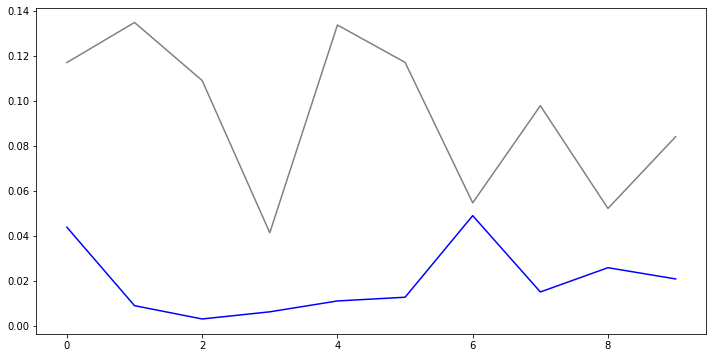

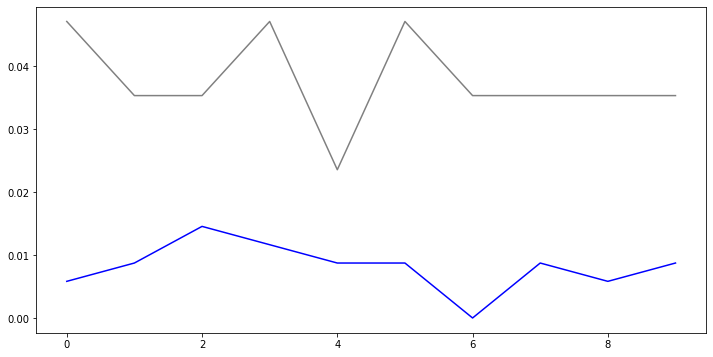

In [36]:

fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(0, 10, 0.1)
y = stats['train_loss']
z = stats['val_loss']
ax.plot(y, color='blue')
ax.plot(z, color='grey')
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
y = stats['train_acc']
z = stats['val_acc']
ax.plot(y, color='blue')
ax.plot(z, color='grey')
plt.show()